In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import scipy
from scipy.signal import stft
import sys
import time
from tqdm.auto import tqdm

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

sys.path.append("../../../../repos/neur_stab/nsta")
from core import estimate_stability_using_particle

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

In [7]:
lfp_full = lfp.copy()

In [8]:
lfp = lfp[:, electrode_info['area'] == 'vlPFC']

In [9]:
lfp.shape

(6504301, 64)

# Get RNN Going

In [10]:
# RANDOM CHAOTIC MODEL
# N = len(electrode_info['area'])
N = 64

In [11]:
q_E = 0.8
N_E = int(q_E)*N
N_I = N - N_E

In [12]:
g = 2.2
tau = 100 # ms
dt = 0.001 # s
# dt = 0.015 # s
W = np.abs(np.random.randn(N, N)*g/np.sqrt(N))
b = np.zeros(N)

In [13]:
weight_scale = np.random.choice([1, -1], size=(N,), p=[q_E, 1 - q_E])

In [14]:
W = np.multiply(W, weight_scale)
# balance the weights
# first naively
for i in range(W.shape[0]):
    pos_weights = W[i][W[i] > 0]
    neg_weights = W[i][W[i] <= 0]
    W[i][W[i] <= 0] *= -pos_weights.sum()/neg_weights.sum()

In [15]:
# noise_sigma = 0.01
noise_sigma = 0

wake_mins = 15
induction_mins = 15
during_mins = 45
post_mins = 15

# wake_mins = 1
# induction_mins = 1
# during_mins = 1
# post_mins = 1

# wake_mins = 0.1
# induction_mins = 0.1
# during_mins = 0.1
# post_mins = 0.1

# wake_scale = 0.5
# during_scale = 1
# post_scale = 0.5

wake_scale = 1.2
during_scale = 1.5
post_scale = 1.2

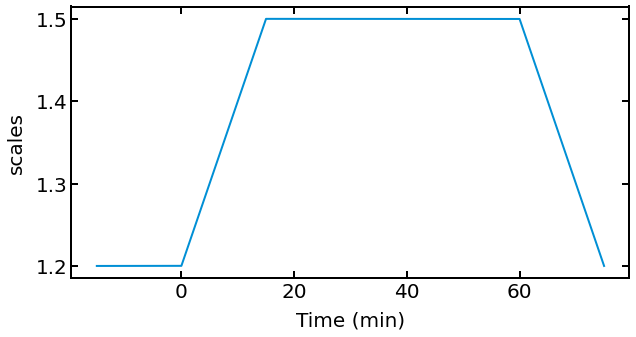

In [16]:
scales = np.hstack([[wake_scale]*int(wake_mins*60*int(1/dt)), np.linspace(wake_scale, during_scale, int(induction_mins*60*int(1/dt))), [during_scale]*int(during_mins*60*int(1/dt)), np.linspace(during_scale, post_scale, int(post_mins*60*int(1/dt)))])

T = int((wake_mins + induction_mins + during_mins + post_mins)*60*int(1/dt))

plt.plot(np.arange(scales.shape[0])/(int(1/dt)*60) - wake_mins, scales)
plt.xlabel("Time (min)")
plt.ylabel('scales')
plt.show()

In [17]:
x = np.zeros((T, N))
Js = np.zeros((T-1, N, N))
x[0] = np.random.randn(N)
W_eff = W.copy()
neg_inds = W < 0
I = np.eye(N)
alpha = (int(dt*1000)/tau)
for t in tqdm(range(1, T)):
    W_eff[neg_inds] = W[neg_inds]*scales[t]
    x[t] = x[t - 1] + alpha*(-x[t - 1] + W_eff @ np.tanh(x[t - 1]) + b + np.sqrt(2/alpha)*np.random.randn()*noise_sigma)
    Js[t - 1] = -I + dt*np.multiply(W_eff, 1 - np.tanh(x[t - 1])**2)

  0%|          | 0/5399999 [00:00<?, ?it/s]

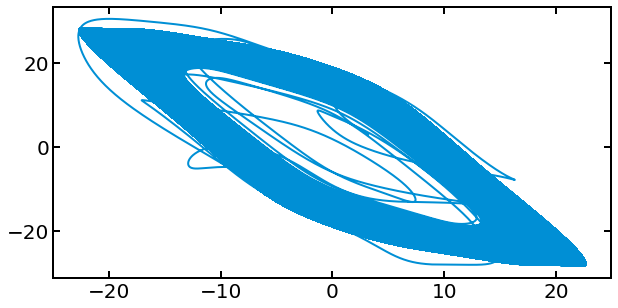

In [18]:
proj1 = x @ np.random.randn(N)
proj2 = x @ np.random.randn(N)
plt.plot(proj1, proj2)
plt.show()

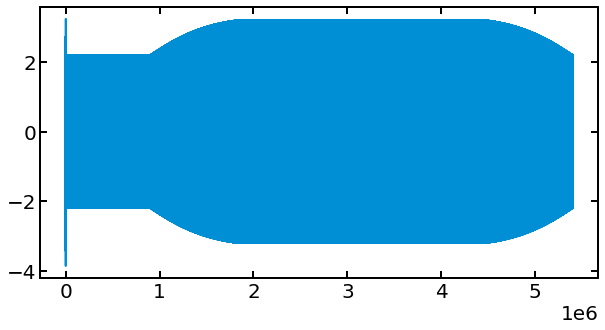

In [19]:
plt.plot(x[:, 1])
plt.show()

In [20]:
window = 2 # s
p = 50
window_ms = int(window/dt)
num_windows = int(np.ceil(Js.shape[0]/window_ms))
lams = np.zeros((num_windows, p))
for i in tqdm(range(num_windows)):
    window_Js = Js[i*window_ms:np.min([(i+1)*window_ms, Js.shape[0]])]
    lams[i] = estimate_stability_using_particle(window_Js, p)

  0%|          | 0/2700 [00:00<?, ?it/s]

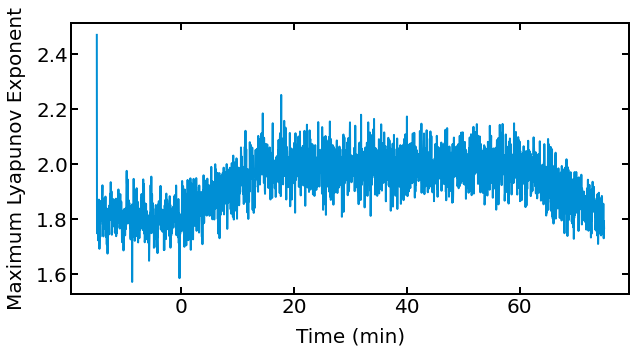

In [21]:
plt.plot(np.arange(lams.shape[0])*window/60 - wake_mins, (lams/dt).mean(axis=1))
plt.xlabel('Time (min)')
plt.ylabel('Maximum Lyapunov Exponent')
plt.show()

In [22]:
eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [23]:
indices = np.random.choice(np.arange(lfp.shape[1]), size=(N,))
neural_data = lfp[int(session_info['drugStart'][0]/0.001) - 15*60*1000:int(session_info['drugEnd'][1]/0.001) + 15*60*1000, indices]

In [24]:
# neural_data = lfp[int(session_info['drugStart'][0]/0.001) - 15*60*1000:int(session_info['drugEnd'][1]/0.001) + 15*60*1000]

In [25]:
neural_data = neural_data[np.arange(0, neural_data.shape[0], int(dt*1000))]

In [26]:
neural_data = neural_data[:x.shape[0]]

In [27]:
window = 2 # s
window = int(window/dt)
num_windows = int(neural_data.shape[0]/window)
disparity = np.zeros(num_windows)
random_disparity = np.zeros(num_windows)
for window_ind in tqdm(range(num_windows)):
    simulated = x[window_ind*window:(window_ind + 1)*window]
    neural = neural_data[window_ind*window:(window_ind + 1)*window]
    mtx1, mtx2, disparity[window_ind] = scipy.spatial.procrustes(simulated, neural)
    _, _, random_disparity[window_ind] = scipy.spatial.procrustes(neural, np.random.randn(*simulated.shape))

  0%|          | 0/2700 [00:00<?, ?it/s]

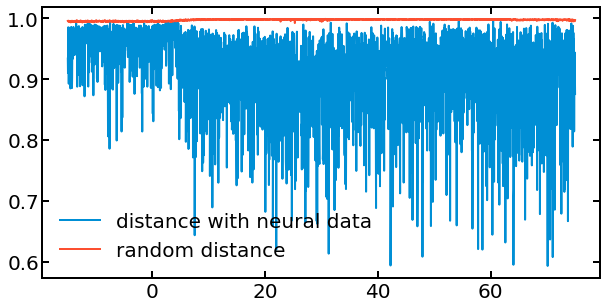

In [28]:
plt.plot(np.arange(disparity.shape[0])*window*dt/60 - 15, disparity, label='distance with neural data')
plt.plot(np.arange(disparity.shape[0])*window*dt/60 - 15, random_disparity, label='random distance')
plt.legend()
plt.show()

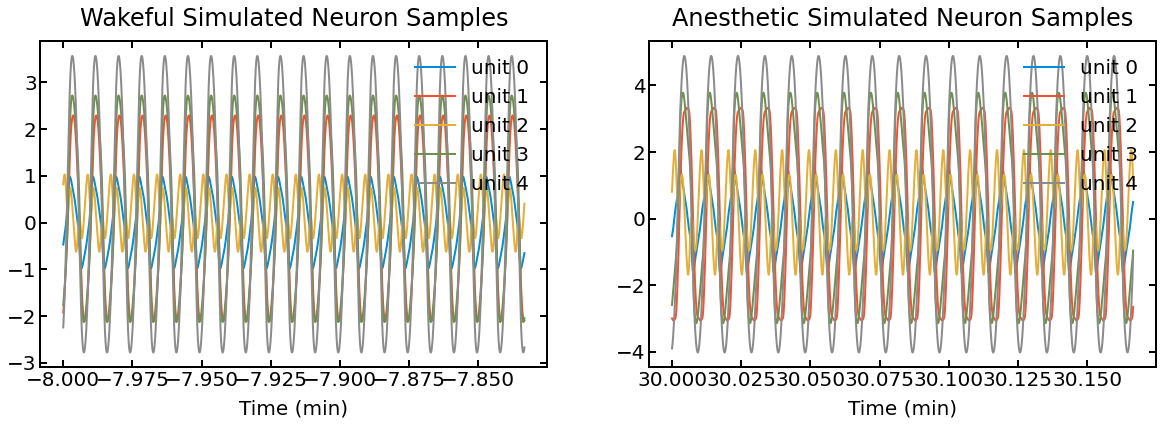

In [29]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
start_time = 7 # minutes
duration = 10 # s
for i in range(5):
    time_series = x[start_time*60*int(1/dt):start_time*60*int(1/dt) + duration*int(1/dt), i]
    plt.plot(start_time + np.arange(time_series.shape[0])*dt/60 - 15, time_series - time_series.mean() + i*0.1, label=f'unit {i}')
plt.legend()
plt.xlabel('Time (min)')
plt.title("Wakeful Simulated Neuron Samples")
plt.subplot(1, 2, 2)
start_time = 45 # minutes
duration = 10 # s
for i in range(5):
    time_series = x[start_time*60*int(1/dt):start_time*60*int(1/dt) + duration*int(1/dt), i]
    plt.plot(start_time + np.arange(time_series.shape[0])*dt/60 - 15, time_series - time_series.mean() + i*0.1, label=f'unit {i}')
plt.legend()
plt.xlabel('Time (min)')
plt.title("Anesthetic Simulated Neuron Samples")
plt.show()